# Tutorial 07 - Stereo

## Dr. David C. Schedl

Note: this tutorial is geared towards students **experienced in programming** and aims to introduce you to **Computer Vision** techniques.


Useful links:
* General OpenCV Tutorials: https://docs.opencv2.org/master/d9/df8/tutorial_root.html
* Image Processing in Pyhton: https://github.com/xn2333/OpenCV/blob/master/Seminar_Image_Processing_in_Python.ipynb
* OpenCV Camera Calibration Tutorials: https://docs.opencv.org/master/d9/db7/tutorial_py_table_of_contents_calib3d.html




# Table of Contents  

- Initialization
- Calibration
- Stereo Calibration
- Epipolar Geometry


<a id="Initialization"></a>

# Initialization

As always let's import useful libraries, first. 
We will work with images today. So let's download some with `curl`.
Let's define utility functions to display images, in Jupyter Notebooks. OpenCV's `imshow` does not work and matplotlib's `imshow` needs special treatment due to color channel handling (RGB vs. BGR)

In [1]:
%%capture 
# %% capture suppress any output

if 'google.colab' in str(get_ipython()):
  # install a newer opencv version on Colab. The default does not support SIFT!
  !pip install opencv-contrib-python==4.5.*




# import the libraries we use
import os
import cv2 # openCV
import numpy as np
import matplotlib.pyplot as plt
from glob import glob



if not os.path.isdir('data'):
  os.mkdir('data')

 
# downloading images from the official OpenCV Github repository!
for lr in ['left','right']:
  for i in range(14):
    src = "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/{:}{:02d}.jpg".format(lr, i+1)
    dst = "data/{:}{:02d}.jpg".format(lr, i+1)
    !curl -o {dst} {src}

# utility function(s)
def imshow(image, *args, **kwargs):
    """A replacement for cv2.imshow() for use in Jupyter notebooks using matplotlib.

        Args:
          image : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
            (N, M, 3) is an NxM BGR color image. 
    """
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion  
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw the image
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')
    # Make sure it outputs
    # plt.show()

def splitfn(fn):
    """ utility function to get the path, filename and the extionsion 
        from https://github.com/opencv/opencv/blob/master/samples/python/common.py
    """
    path, fn = os.path.split(fn)
    name, ext = os.path.splitext(fn)
    return path, name, ext

# Calibration


## Finding checkerboard corners

We can use `cv2.findChessboardCorners(img, pattern_size)` to find the checkerboard corners ($u,v$) in the image. The 3D coordinates of the corners are known, since they are known points on a plane. With `cv2.cornerSubPix` the image locations can be found with sub-pixel accuracy. 

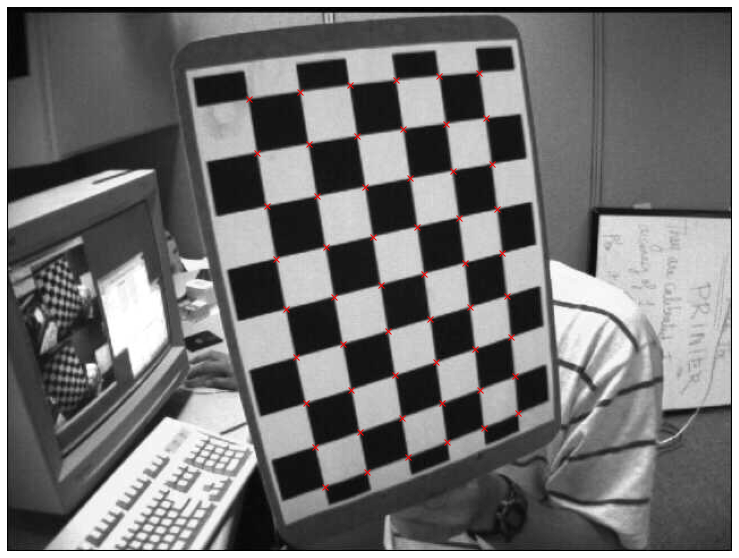

In [2]:

def processImage(img):
    if img is None:
        print("Image is None!")
        return None

    # parameters of the checkerboard
    square_size = 1.0

    pattern_size = (9, 6)
    pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
    pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)
    pattern_points *= square_size

    found, corners = cv2.findChessboardCorners(img, pattern_size)
    if found: # refine corner with sub-pixel accuracy
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.1)
        corners = cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)

    if not found:
        print('chessboard not found')
        return None

    return (corners.reshape(-1, 2), pattern_points)

img = cv2.imread( './data/left14.jpg', cv2.IMREAD_GRAYSCALE )
(corners, pattern_points) = processImage( img )
#print(corners, pattern_points)

plt.figure(figsize=(15,10))
imshow(img, cmap='gray')
plt.plot(corners[:,0], corners[:,1], 'rx')
plt.show()

## Computing the intrinsic, extrinsic and distortion parameters

With `cv2.calibrateCamera(obj_points, img_points, (w, h)` and the 2D to 3D correspondences we can compute the intrinsic, extrinsic and distortion parameters. 

In [3]:
# process all images
img_mask = './data/left??.jpg'  # default
img_names = sorted(glob(img_mask))

images = [ cv2.imread(fn,cv2.IMREAD_GRAYSCALE) for fn in img_names ]
images = [ x for x in images if x is not None ] # filter empty images
h, w = images[0].shape[:2]

# find corners for all images
chessboards = [processImage( img ) for img in images] # process all images
chessboards = [x for x in chessboards if x is not None] # filter images that did not work!
img_points, obj_points = [],[]
for (corners, pattern_points) in chessboards:
    img_points.append(corners)
    obj_points.append(pattern_points)

# calculate camera distortion
rms, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, (w, h), None, None)

print("\nRMS:", rms)
print("camera matrix:\n", camera_matrix)
print("distortion coefficients: ", dist_coefs.ravel())



RMS: 0.1964379089033398
camera matrix:
 [[532.79536562   0.         342.4582516 ]
 [  0.         532.91928338 233.90060514]
 [  0.           0.           1.        ]]
distortion coefficients:  [-2.81086258e-01  2.72581018e-02  1.21665908e-03 -1.34204275e-04
  1.58514022e-01]


## Reprojection

Let's verify the model by projection 3D points onto our checkerboard again. The root-mean-squared (RMS) error is the distance between the found points and the projected known 3D points. Ideally the RMS is very small.


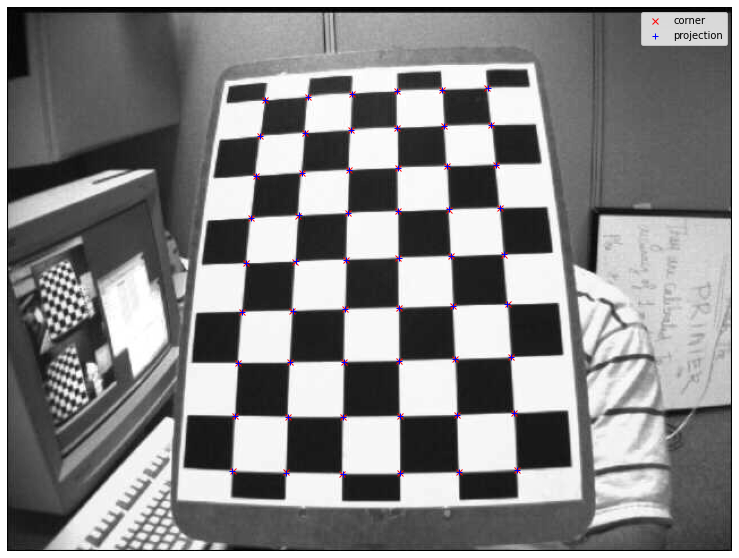

In [4]:
# let's verify the model by projection 3D points onto our checkerboard corners!

img_id = 10
img = images[img_id]
#dst = cv2.undistort(img, camera_matrix, dist_coefs, None, camera_matrix)
pattern_points = obj_points[0]

imgpts, jac = cv2.projectPoints( pattern_points, rvecs[img_id], tvecs[img_id], camera_matrix, dist_coefs  )

plt.figure(figsize=(15,10))
imshow(img, cmap='gray')
plt.plot(img_points[img_id][:,0], img_points[img_id][:,1], 'rx', label='corner')
plt.plot(imgpts[:,:,0], imgpts[:,:,1], 'b+', label='projection')
plt.legend()
plt.show()

## Undistort

Furthermore, we can remove any lens distortions from the images. After undistorition the pinhole model can be applied.

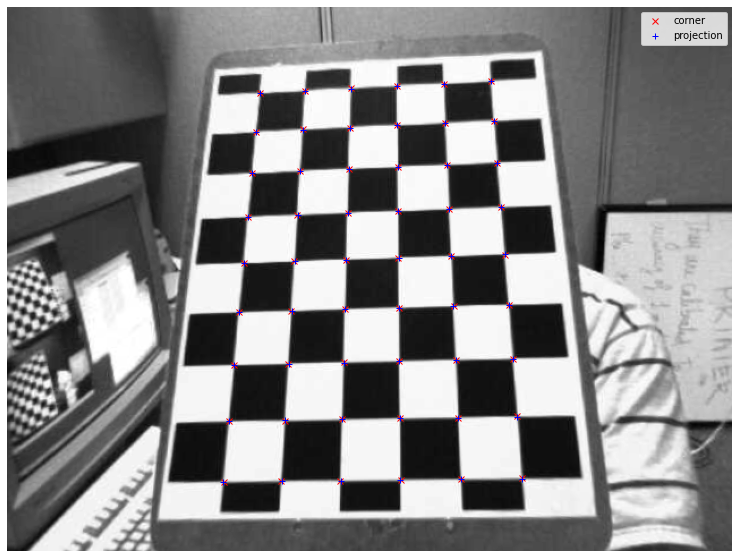

In [5]:
# let's remove the lens distortions

img_id = 10 # pick any image you want to display
img = images[img_id]

# remove the the lens distortions
dst = cv2.undistort(img, camera_matrix, dist_coefs, None, camera_matrix)
pattern_points = obj_points[0]

# projecting points can be done without any distortions parameters, now
imgpts, jac = cv2.projectPoints( pattern_points, rvecs[img_id], tvecs[img_id], camera_matrix, None  )

# the original detections were done in the distorted image, so they also require correction
dst_points = cv2.undistortPoints( img_points[img_id], camera_matrix, dist_coefs, None, camera_matrix )

plt.figure(figsize=(15,10))
imshow(dst, cmap='gray')
plt.plot(dst_points[:,:,0], dst_points[:,:,1], 'rx', label='corner')
plt.plot(imgpts[:,:,0], imgpts[:,:,1], 'b+', label='projection')
plt.legend()
plt.show()

##  ⌨️ Try it yourself: Manual projection

Try to project the points without using `cv2.projectPoints`. Note that the pinhole model can be applied with the undistorted images. So 3D points $X$ can be projected into the image $x$ by 
$$
x = K [R \  t] X
$$
or
$$
x = K P X
$$ 
where $P = [R \ t]$ (3x4 matrix). 
Remember that $x$ and $X$ uses homogeneous coordinates. Before plotting them on the image they need to be converted to non-homogeneous coordinates. 

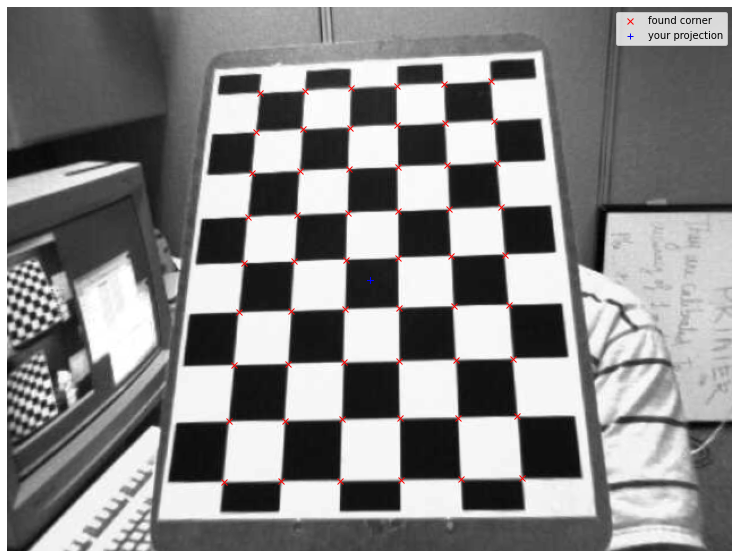

In [6]:
pts3D = pattern_points
K = camera_matrix # intrinsic (3x3)
R,_ = cv2.Rodrigues(rvecs[img_id])# extrinsic matrix as 3x3 matrix
t = tvecs[img_id] # extrinsic translation (3D vector)

P = np.hstack((R,t))

# projecting points can be done without any distortions parameters 
uvs = np.zeros(shape=(2,0))
for pt3D in pts3D:
  
  
  uv = [w/2,h/2] # ToDo: change this line!

  uvs = np.column_stack((uvs,uv)) # store

# display
plt.figure(figsize=(15,10))
imshow(dst, cmap='gray')
plt.plot(dst_points[:,:,0], dst_points[:,:,1], 'rx', label='found corner')
plt.plot(uvs[0], uvs[1], 'b+', label='your projection')
plt.legend()
plt.show()

# (A poor man's) Augmented Reality (AR)

Let's put some 3D content on our checkerboard. We assume the checkerboard is the ground plane. 

[298.53232 118.38401]
[[[182.81795 126.50001]]]


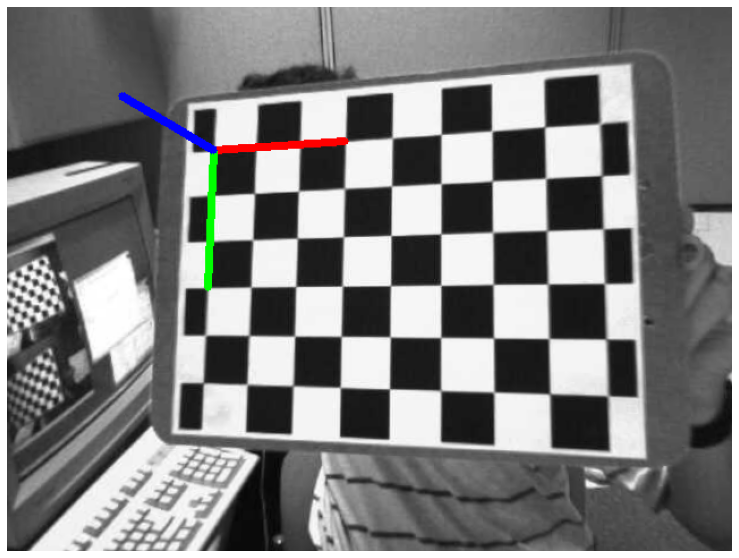

In [7]:
# let's add a 3D content on our image, a debug axis

img_id = 3 # select an image (0 to 12)
img = images[img_id]
dst = cv2.undistort(img, camera_matrix, dist_coefs, None, camera_matrix)
pattern_points = obj_points[0]

axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)
axis_imgpts, jac = cv2.projectPoints( axis, rvecs[img_id], tvecs[img_id], camera_matrix, None  )
print(axis_imgpts[0].ravel())

origin = np.float32([[0,0,0]]).reshape(-1,3)
origin_imgpts, jac = cv2.projectPoints( origin, rvecs[img_id], tvecs[img_id], camera_matrix, None  )
print(origin_imgpts)

def drawAxes(img, corners, imgpts):
    corner = np.int32(corners[0].ravel())
    img = cv2.line(img, corner, np.int32(imgpts[0].ravel()), (0,0,255), 5) # x -> red
    img = cv2.line(img, corner, np.int32(imgpts[1].ravel()), (0,255,0), 5) # y -> green
    img = cv2.line(img, corner, np.int32(imgpts[2].ravel()), (255,0,0), 5) # z -> blue
    return img

vis = cv2.cvtColor( dst, cv2.COLOR_GRAY2BGR)
drawAxes(vis, origin_imgpts, axis_imgpts)

# display
plt.figure(figsize=(15,10))
imshow(vis, cmap='gray')
plt.show()

##  ⌨️ Try it yourself: Your 3D object

Draw your own 3D object by drawing 3D lines and polygons on our image. 
For example, you can draw a colored cube, a house, a car, ... 



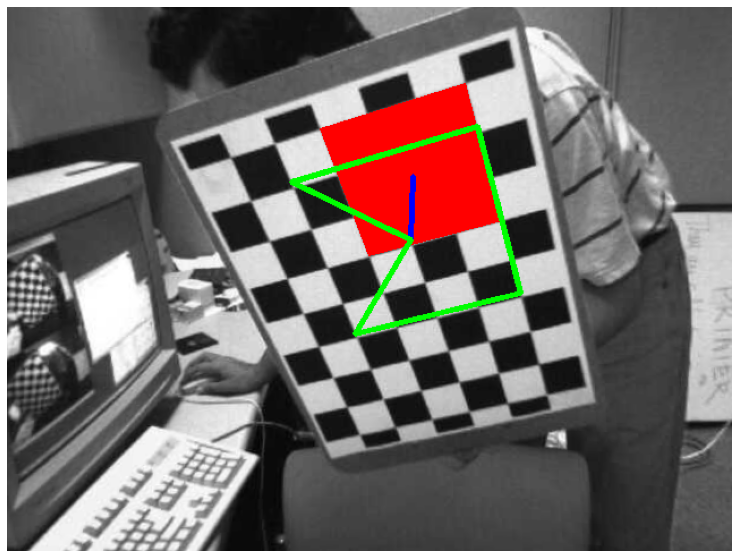

In [8]:
img_id = 11 # select an image (0 to 12)
img = images[img_id]
dst = cv2.undistort(img, camera_matrix, dist_coefs, None, camera_matrix)
vis = cv2.cvtColor( dst, cv2.COLOR_GRAY2BGR)

def draw3DPolygon( vis, axis, color, filled, Rv, tv, K, dist_coefs=None ):

  axis = np.asarray(axis, dtype=np.float32).reshape(-1,3) # make sure it has the correct format
  axis_imgpts, jac = cv2.projectPoints( axis, Rv, tv, K, dist_coefs )

  if filled: # fill the polygon or only draw the contour 
    thickness = -3
  else:
    thickness = 3


  vis = cv2.drawContours(vis, [np.asarray(axis_imgpts.reshape(-1,2),dtype=np.int32)],-1,color,thickness)

# draw filled polygon
draw3DPolygon( vis, [[0,0,0], [3,0,0], [3,3,0], [0,3,0]], (0,0,255), True, rvecs[img_id], tvecs[img_id], camera_matrix, None )
# draw a line
draw3DPolygon( vis, [[1.5,1.5,-3], [1.5,1.5,0]], (255,0,0), False, rvecs[img_id], tvecs[img_id], camera_matrix, None )
# draw non-filled contour
draw3DPolygon( vis, [[0,0,-3], [3,0,-3], [3,3,-3], [1.5,1.5,-3], [0,3,-3]], (0,255,0), False, rvecs[img_id], tvecs[img_id], camera_matrix, None )


# display
plt.figure(figsize=(15,10))
imshow(vis, cmap='gray')
plt.show()

# Stereo Calibration

Let's calibrate two cameras that record simultaneously. So we always get a pair of images (left and right).

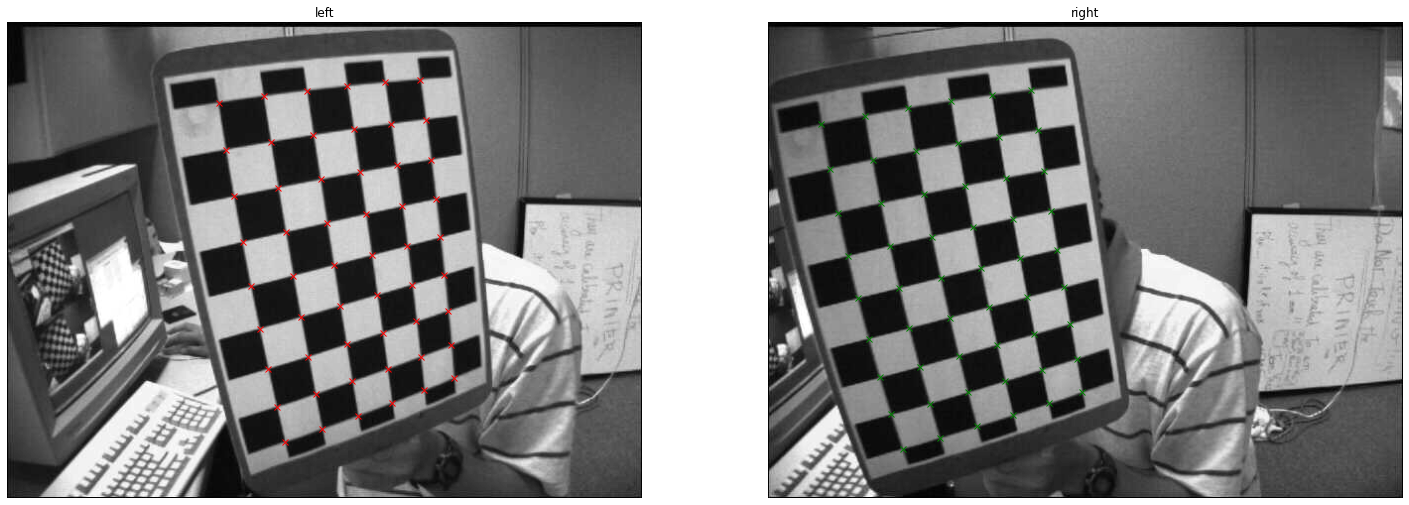

In [9]:
left = cv2.imread( './data/left14.jpg', cv2.IMREAD_GRAYSCALE )
(left_corners, left_pattern_points) = processImage( left )
right = cv2.imread( './data/right14.jpg', cv2.IMREAD_GRAYSCALE )
(right_corners, right_pattern_points) = processImage( right )


plt.figure(figsize=(25,10))
plt.subplot(121), plt.title('left')
imshow(left, cmap='gray')
plt.plot(left_corners[:,0], left_corners[:,1], 'rx')

plt.subplot(122), plt.title('right')
imshow(right, cmap='gray')
plt.plot(right_corners[:,0], right_corners[:,1], 'gx')

plt.show()

We calibrated the left camera already. Let's do the same for the right camera.

In [10]:
# the previous data is for the left image
left_images = images
left_img_points = img_points
left_cam_mat, left_dist_coefs = camera_matrix, dist_coefs


# process right images
img_mask = './data/right??.jpg'  # default
img_names = sorted(glob(img_mask))

right_images = [ cv2.imread(fn,cv2.IMREAD_GRAYSCALE) for fn in img_names ]
right_images = [ x for x in right_images if x is not None ] # filter empty images
assert len(right_images)==len(left_images), "the number of left and right images does not match!"

# find corners for all images
chessboards = [processImage( img ) for img in right_images] # process all images
chessboards = [x for x in chessboards if x is not None] # filter images that did not work!
right_img_points = []
for (corners, pattern_points) in chessboards:
    right_img_points.append(corners)

# calculate camera distortion
rms, right_cam_mat, right_dist_coefs, rvecs, tvecs = cv2.calibrateCamera(obj_points, right_img_points, (w, h), None, None)

print("-RIGHT CAMERA-\nRMS:", rms)
print("camera matrix:\n", right_cam_mat)
print("distortion coefficients: ", right_dist_coefs.ravel())


-RIGHT CAMERA-
RMS: 0.2074668759042666
camera matrix:
 [[537.42795278   0.         327.61420336]
 [  0.         536.94702919 248.88429323]
 [  0.           0.           1.        ]]
distortion coefficients:  [-0.29743205  0.14940541 -0.00076609  0.0003211  -0.06579229]


## Relative Transformation, Fundamental and Essential Matrix
OpenCV provides a `stereoCalibrate` function that computes the relative rotation and translation of the two cameras.

In [11]:
# calibrate the stereo setup, with the individual matrices and distortion coefficients of left and right
rms, left_cam_mat, left_dist_coeffs, right_cam_mat, right_dist_coeffs, R, t, E, F \
    = cv2.stereoCalibrate( obj_points, left_img_points, right_img_points, left_cam_mat, left_dist_coefs, right_cam_mat, right_dist_coefs, (w,h) )
    

print("-STEREO-\nRMS:", rms)
print("left camera matrix:\n", left_cam_mat)
print("right camera matrix:\n", right_cam_mat)
print("left distortion:  ", left_dist_coeffs.ravel())
print("right distortion: ", right_dist_coeffs.ravel())

print("relative rotation:\n", R)
print("relative translation:\n", t)
print("essential matrix:  ", E)
print("fundamental matrix: ", F)

-STEREO-
RMS: 0.21757590127371687
left camera matrix:
 [[532.79536562   0.         342.4582516 ]
 [  0.         532.91928338 233.90060514]
 [  0.           0.           1.        ]]
right camera matrix:
 [[537.42795278   0.         327.61420336]
 [  0.         536.94702919 248.88429323]
 [  0.           0.           1.        ]]
left distortion:   [-2.81086258e-01  2.72581018e-02  1.21665908e-03 -1.34204275e-04
  1.58514022e-01]
right distortion:  [-0.29743205  0.14940541 -0.00076609  0.0003211  -0.06579229]
relative rotation:
 [[ 0.99998578  0.00376589  0.00377484]
 [-0.00374027  0.99997007 -0.00677299]
 [-0.00380023  0.00675878  0.99996994]]
relative translation:
 [[-3.32806101]
 [ 0.03738435]
 [ 0.01469882]]
essential matrix:   [[-8.70915837e-05 -1.44457047e-02  3.74827803e-02]
 [ 2.05121556e-03  2.25489855e-02  3.32801645e+00]
 [-2.49359834e-02 -3.32810218e+00  2.23998205e-02]]
fundamental matrix:  [[ 4.67950377e-09  7.75999334e-07 -1.25614910e-03]
 [-1.10312245e-07 -1.21237907e-06

## Relation between $R, t, E$ and $F$

### Essential Matrix $E$
The Essential Matrix $E$ can be expressed by $R$ and $t$ as:

$$ E = [t]_{\times} R, $$

 where $[t]_{\times}$ is the matrix representation of the cross product:

$$
[t]_{\times} =
\begin{bmatrix}
{0}&{-t_2}&{t_1}\\{t_2}&{0}&{-t_0}\\{-t_1}&{t_0}&{0}
\end{bmatrix}
$$

### Fundamental matrix $F$
The fundamental matrix $F$ can be computed by $E$ and the two camera matrices $K$ and $K'$ by:
$$
F = K'^{-T} E K^{-1},
$$
where $K'^{-T}$ refers to the inverse and transpose of the second intrinsic camera matrix.

Note that $F$ and $E$ might be scaled by a scalar (e.g., $sF$), which, however, does not influence the epipolar geomtry.

Furthermore, note that typically the fundamental matrix $F$ is estimated and then the intrinsics and the essential matrix $E$ are estimated from $F$. 
By inverting the equation above we get:
$$
E = K'^{\ T} F K
$$



In [12]:
# The essential matrix
print( "E = [t]x * R: ", np.cross(np.eye(3), t.ravel()) @ R )

# The fundamental matrix expressed by K1, K2 and E
_F = np.linalg.inv(right_cam_mat).transpose() @ E @ np.linalg.inv(left_cam_mat)
print( "F: ", (_F / _F[-1,-1]) ) # normalize

# Vice versa, the essential matrix can be computed by F, K1 and K2
_E = ( right_cam_mat.transpose() @ F @ left_cam_mat )
print( "E: ", _E / _E[-1,-1]) # normalize

E = [t]x * R:  [[-8.70915837e-05 -1.44457047e-02  3.74827803e-02]
 [ 2.05121556e-03  2.25489855e-02  3.32801645e+00]
 [-2.49359834e-02 -3.32810218e+00  2.23998205e-02]]
F:  [[ 4.67950377e-09  7.75999334e-07 -1.25614910e-03]
 [-1.10312245e-07 -1.21237907e-06 -9.50369077e-02]
 [ 7.45984699e-04  9.61289574e-02  1.00000000e+00]]
E:  [[-3.88804828e-03 -6.44902696e-01  1.67335181e+00]
 [ 9.15728569e-02  1.00665920e+00  1.48573353e+02]
 [-1.11322247e+00 -1.48577181e+02  1.00000000e+00]]


# Epipolar Geometry

Let's compute the epipolar lines for the checkerboard corner points in both left and right images. 
Since the cameras' image axes are almost parallel the epipolar lines are almost parallel as well.

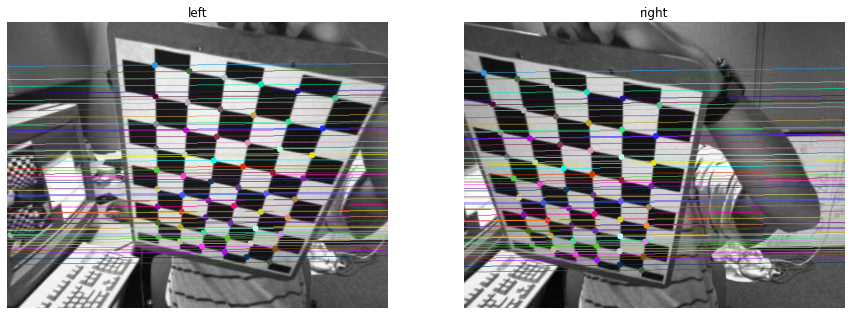

In [13]:
# let's draw the epipolar lines

img_id = 1 # select an image (0 to 12)
left = left_images[img_id]
left = cv2.undistort(left, left_cam_mat, left_dist_coeffs, None, left_cam_mat)
left_points = cv2.undistortPoints( left_img_points[img_id], left_cam_mat, left_dist_coeffs, None, left_cam_mat )
right = right_images[img_id]
right = cv2.undistort(right, right_cam_mat, right_dist_coeffs, None, right_cam_mat)
right_points = cv2.undistortPoints( right_img_points[img_id], right_cam_mat, right_dist_coeffs, None, right_cam_mat )

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    lines = lines.reshape(-1,3)
    np.random.seed(42)
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,np.int32(pt1.ravel()),5,color,-1)
        img2 = cv2.circle(img2,np.int32(pt2.ravel()),5,color,-1)
    return img1,img2

left_lines = cv2.computeCorrespondEpilines(right_points, 2, F)
left_vis, _ = drawlines( left, right, left_lines, left_points, right_points )

right_lines = cv2.computeCorrespondEpilines(left_points, 1, F)
right_vis, _ = drawlines( right, left, right_lines, right_points, left_points )

# display
plt.figure(figsize=(15,10))
plt.subplot(121), plt.title( 'left' )
imshow(left_vis, cmap='gray')
plt.subplot(122), plt.title( 'right' )
imshow(right_vis, cmap='gray')
plt.show()

# Stereo Image Rectification

Reproject image planes onto a common plane parallel to the line between camera centers. 
Epipolar lines are horizontal scanlines after this transformation.
We can use `cv2.stereoRectify` to compute the desired transfromation matrices.


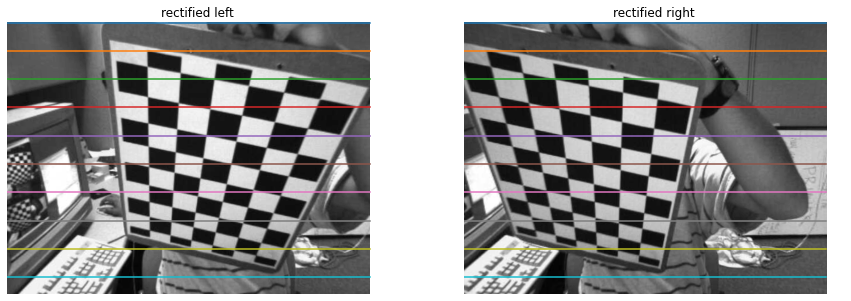

In [14]:
img_id = 1

R1, R2, P1, P2, Q, validPixROI1, validPixROI2 = cv2.stereoRectify(left_cam_mat, left_dist_coeffs, right_cam_mat, right_dist_coeffs,(w,h), R, t)

# left
map1x, map1y = cv2.initUndistortRectifyMap(left_cam_mat, left_dist_coeffs, R1, P1, (w, h), cv2.CV_32FC1)
rleft = cv2.remap( left_images[img_id], map1x, map1y, cv2.INTER_LINEAR )

# right
map2x, map2y = cv2.initUndistortRectifyMap(right_cam_mat, right_dist_coeffs, R2, P2, (w, h), cv2.CV_32FC1)
rright = cv2.remap( right_images[img_id], map2x, map2y, cv2.INTER_LINEAR )

# display
plt.figure(figsize=(15,10))
plt.subplot(121), plt.title( 'rectified left' )
imshow(rleft, cmap='gray')
for y in range(0,h,50):
  plt.plot([0,w],[y,y])
plt.subplot(122), plt.title( 'rectified right' )
imshow(rright, cmap='gray')
for y in range(0,h,50):
  plt.plot([0,w],[y,y])
plt.show()
